In [5]:
# importing required packages
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
nlp = spacy.load('en')

from spacy import displacy
#from spacy.lang.en import English
#parser = English()

#from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin 

#from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, cohen_kappa_score

from scipy.sparse import csr_matrix

np.random.seed(42)
%matplotlib inline

In [6]:
# set up display area to show dataframe in jupyter qtconsole

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', 1000)

pd.set_option('display.max_colwidth', -1)

In [7]:
myDir = Path.cwd().parents[0]
dataFolder = myDir / 'data/asap-sas'
ratingsFolder = myDir / 'data/ratings'

print(dataFolder)

gradeMap = {1: 10,
                2: 10,
                3: 10,
                4:10,
                5: 10,
                6: 10,
                7:10,
                8:10,
                9:10,
                10:8}

subjectMap = {1: 'Science',
            2: 'Science',
            3: 'English Language Arts',
            4: 'English Language Arts',
            5: 'Biology',
            6: 'Biology',
            7:'English',
            8:'English',
            9:'English',
            10:'Science'}

scoreMap = {0: 0,
            1: 1,
            2: 2,
            3: 2}

df = pd.read_csv(dataFolder/'train.tsv', sep='\t', header=0)  #read data into dataframe
df.drop('Score2', inplace=True, axis=1) #Score 2 is for inter-rate reliability only

df['subject'] = df['EssaySet'].map(subjectMap)
df['studentGrade'] = df['EssaySet'].map(gradeMap)
df['styleScore'] = df['Score1'].map(scoreMap)

df = df[['Id','EssaySet','subject','studentGrade','EssayText','Score1','styleScore']] #rearrange columns

df.head()

C:\Users\Devanshi\Desktop\finalProject\data\asap-sas


,Id,EssaySet,subject,studentGrade,EssayText,Score1,styleScore
0,1,1,Science,10,"Some additional information that we would need to replicate the experiment is how much vinegar should be placed in each identical container, how or what tool to use to measure the mass of the four different samples and how much distilled water to use to rinse the four samples after taking them out of the vinegar.",1,1
1,2,1,Science,10,"After reading the expirement, I realized that the additional information you need to replicate the expireiment is one, the amant of vinegar you poured in each container, two, label the containers before you start yar expirement and three, write a conclusion to make sure yar results are accurate.",1,1
2,3,1,Science,10,"What you need is more trials, a control set up, and an exact amount of vinegar to pour in each cup/beaker. You could also take and check the mass every 30 min or 1 hour.",1,1
3,4,1,Science,10,The student should list what rock is better and what rock is the worse in the procedure.,0,0
4,5,1,Science,10,"For the students to be able to make a replicate, they would need to tell use how much vinegar is used and what tipe of materials is needed for the expirement.",2,2


In [8]:
# Take only essay set 1
set_1 = df[(df['EssaySet'] == 1)].copy()
set_1.shape

(1672, 7)

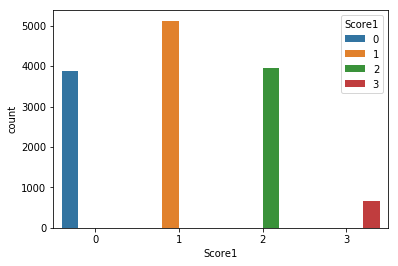

In [5]:
#plt.figure(figsize=(5,5))
sns.countplot(x="Score1", data=df[~(df.subject == "Biology")], orient='v', hue="Score1")

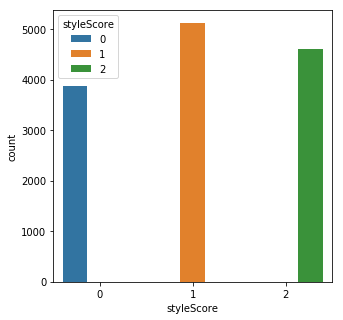

In [6]:
plt.figure(figsize=(5,5))
sns.countplot(x="styleScore", data=df[~(df.subject == "Biology")], orient='v', hue="styleScore")

In [37]:
# df = df[~(df.subject == "Biology")] #Remove Biology
# del df

In [9]:
X = set_1[['EssayText','styleScore']]
y = X.pop('styleScore')


train, test, y_train_tmp, y_test_tmp = train_test_split(X, y, test_size=0.30, random_state=42)

#Adding the is_copy to False otherwise we get SettingWithCopyWarning
train = train.copy()
test = test.copy()

train.head()

,EssayText
1145,"You would need to know how much vinegar was put in to each sample, find the size and shape of the container so the same amount of vinegar was actually covering the sample. You would need to know the shape or volume of sample because the surface are has to be the same so the same amount is affected by the vinegar."
842,"In order to replicate experiment I would need to know exactly how much vinegar to pour in each container, how much of each sample to put in the container, and"
1554,The additional information you would need in order to replicate the experiment form a hypothesis. Draw a conclusion. Say what you are experimenting.
1526,To replicate this experiment you would need to state you problem. What is the person for this lab also you need to indicate your independent and dependent variables.
497,1) I would need to know how much vinegar is being put into the sample. ^p 2) What are they trying to find out through pass is to amount. ^p 3) Was there a control group in this experiment.


In [46]:
def spacy_tokenizer(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    doc_tokens = []

    doc = nlp(doc, disable=['parser','ner','textcat'])
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.text.lower().strip() if w.pos_ == 'PRON' else w.lemma_.lower().strip() for w in doc]


def spacy_pos_tagger(doc):
    
    doc = nlp(doc, disable=['parser','ner','textcat'])
    
    return [w.pos_ for w in doc] 



## Feature Extraction

In [113]:
def get_custom_features(col, scale_values):
    
    features_df = pd.DataFrame(index=col.index)
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    total_words = []
    words_no_punct = []
    words_no_punct_no_stop =[]
    count_content_words=[]
    count_stopwords=[]
    avg_word_len = []
    
    
    aoa_ratings_df = pd.read_csv(ratingsFolder/'AoA_Ratings.csv')
    aoa_ratings = dict(zip(aoa_ratings_df.Word, aoa_ratings_df.AoA))
    maturity_tokens = []
    maturity = []

    conc_ratings_df = pd.read_csv(ratingsFolder/'Concreteness_Ratings.csv')
    conc_ratings = dict(zip(conc_ratings_df.Word, conc_ratings_df.Concreteness))
    concreteness = []
    conc_tokens = []    


    for doc in nlp.pipe(col, batch_size=50, n_threads=4):

        if doc.is_parsed:
            
            #Add placeholders for CONTENT words, else parse as usual
            #tokens.append(['__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc])
            
            total_words.append(len([w.text for w in doc]))
            words_no_punct.append(len([w.text for w in doc if not w.is_punct]))
            words_no_punct_no_stop.append(len([w.text for w in doc if not w.is_punct if not w.is_stop]))
            count_content_words.append(len([w.text for w in doc if w.pos_ in content_words]))
            count_stopwords.append(len([w.text for w in doc if w.is_stop]))
            avg_word_len.append(sum([len(w) for w in doc if not w.is_punct])/len([w for w in doc if not w.is_punct]))
            
            #-------------------Maturity
            mat_tmp = []
            maturity_tokens.append([w.text.lower().strip() if w.lemma_ == '-PRON-' else w.lemma_.lower().strip() for w in doc])

            #maturity.append([value.get('name') for value in d.values()])
            mat_tmp.append([aoa_ratings[t] for a in maturity_tokens for t in a if t in aoa_ratings])

             #Now get avg maturity per doc
            for j in mat_tmp:
                maturity.append(sum(j)/len(j))

            #----------Concreteness
            conc_tmp = []
            conc_tokens.append([w.text.lower().strip() for w in doc])
            conc_tmp.append([conc_ratings[t] for a in conc_tokens for t in a if t in conc_ratings])

            #Now get avg concreteness per doc
            for k in conc_tmp:
                concreteness.append(sum(k)/len(k))

        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails

            #tokens.append(None)
            total_words.append(None)
            words_no_punct.append(None)
            words_no_punct_no_stop.append(None)
            count_content_words.append(None)
            count_stopwords.append(None)
            avg_word_len.append(None)
            maturity.append(None)
            concreteness.append(None)
    
    features_df['total_words'] = total_words
    features_df['words_no_punct'] = words_no_punct
    features_df['words_no_punct_no_stop'] = words_no_punct_no_stop
    features_df['count_content_words'] = count_content_words
    features_df['count_stopwords'] = count_stopwords
    features_df['avg_word_len'] = avg_word_len
    features_df['maturity'] = maturity
    features_df['concreteness'] = concreteness
    
    col_names = ['total_words','words_no_punct','words_no_punct_no_stop','count_content_words',
                 'count_stopwords','avg_word_len','maturity','concreteness']
    
    if scale_values:
        scaled_features = StandardScaler().fit_transform(train[col_names].astype(float))
        features_df = pd.DataFrame(scaled_features, index=col.index, columns=[col_names])
    
    return features_df

In [12]:
def get_text_ngrams(col, tokenizer, ngram_range, max_features, scale_values):
    
    #Get text BoW n-grams

    #Initialise vectoriser
    count_vectorizer = CountVectorizer(tokenizer=tokenizer,  ngram_range=ngram_range, max_features=max_features)
    
    unscaled_text_ngrams = count_vectorizer.fit_transform(col)
    
    if scale_values:
        print('Scaling values')
        text_ngrams = StandardScaler().fit_transform(unscaled_text_ngrams.astype(float))
    else:
        text_ngrams = unscaled_text_ngrams
    
    ngram_columns = count_vectorizer.get_feature_names()
    
    print(text_ngrams.shape)
    
    return text_ngrams, ngram_columns

In [13]:
def get_pos_ngrams(col, tokenizer, ngram_range, max_features, scale_values):
    
    #Get POS n-grams
    pos_vectorizer = CountVectorizer(tokenizer=tokenizer, ngram_range=ngram_range, max_features=max_features)
    
    unscaled_pos_ngrams = pos_vectorizer.fit_transform(col)
    
    if scale_values:
        print('Scaling values')
        pos_ngrams = StandardScaler().fit_transform(pos_ngrams.astype(float))
    else:
        pos_ngrams = unscaled_pos_ngrams
        
    pos_ngram_columns = pos_vectorizer.get_feature_names()
    
    print(pos_ngrams.shape)
    
    return pos_ngrams, pos_ngram_columns

### Get Features
* custom features

In [162]:
#Get handcrafted features
custom_features_df = get_custom_features(train['EssayText'], scale_values=False)
custom_features_df.head()


,total_words,words_no_punct,words_no_punct_no_stop,count_content_words,count_stopwords,avg_word_len,maturity,concreteness
1145,65,62,22,37,40,4.032258,5.125484,2.293443
842,32,30,13,17,17,4.233333,5.170330,2.344222
1554,26,23,13,15,10,5.347826,5.313158,2.366161
1526,30,28,14,17,14,4.857143,5.422465,2.390000
497,45,39,18,22,21,3.692308,5.353314,2.366512


* N-grams (words)

In [169]:
#Get text based ngrams    
text_ngrams, text_ngrams_columns = get_text_ngrams(train['EssayText'],spacy_tokenizer, (1,1), 10000, scale_values=False )    

text_ngrams_df = pd.DataFrame(text_ngrams.toarray(), columns=text_ngrams_columns, index=train.index)
text_ngrams_df.head()

(1170, 264)


,,,!,"""",#,&,','','s,(,),*,+,",",-,-0.1,-0.4,-1.3,-amount,-compare,-how,-identify,-in,-observe,-round,...,twenty,two,u,under,until,up,us,use.what,used.it,va,vi,water.the,we,well,were.the,wh,whereas,whether,while,with,within,without,wt,you,zero
1145,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
842,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
1526,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
497,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [170]:
from yellowbrick.text import FreqDistVisualizer

Text(0.5,1,'Frequency Distribution of Content Independent uni grams')

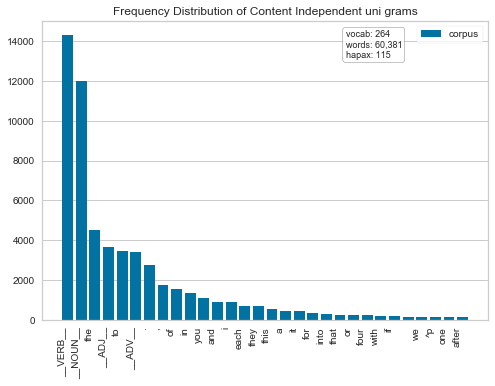

In [200]:
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)

visualizer = FreqDistVisualizer(features=text_ngrams_columns, orient='v',n=30, color='green')
visualizer.fit(text_ngrams)

# Call finalize to draw the final yellowbrick-specific elements
visualizer.finalize()
#visualizer.poof()
# Get access to the axes object and modify labels
visualizer.ax.set_title("Frequency Distribution of Content Independent uni grams")
#visualizer.ax.set_xlabel("Xlabel")
#visualizer.ax.set_ylabel("yLabel")

#visualizer.ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


* n-grams (POS)

In [24]:
pos_ngrams, pos_ngram_columns = get_pos_ngrams(train['EssayText'], spacy_pos_tagger, (1,1), 10000, scale_values=False)
pos_ngrams_df = pd.DataFrame(pos_ngrams.toarray(), 
                             columns=pos_ngram_columns, 
                             index=train.index)

pos_ngrams_df.head()

(1170, 16)


,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
1145,4,7,3,2,10,0,14,0,4,2,0,3,0,0,16,0
842,2,4,3,1,3,0,6,0,4,1,0,2,0,0,6,0
1554,1,1,0,0,4,0,6,0,1,2,0,3,0,0,8,0
1526,3,1,1,1,3,0,6,0,3,3,0,2,0,0,7,0
497,1,3,2,0,3,0,7,3,4,2,0,8,0,0,12,0


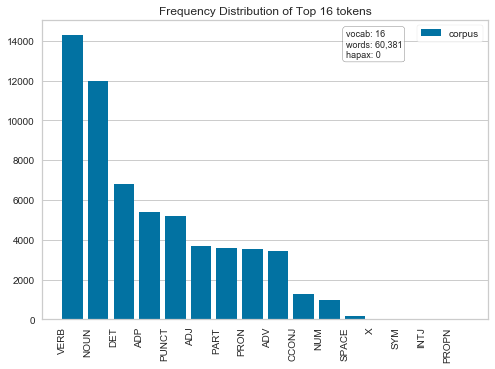

In [204]:
#plt.figure(figsize=(12,10))
visualizer = FreqDistVisualizer(features=pos_ngram_columns, orient='v', n=16)
visualizer.fit(pos_ngrams)
visualizer.poof()

### Concatenate Features & Prepare X & Y 

In [ ]:
# Concatenate all the features
merged_1 = pd.merge(custom_features_df, pos_ngrams_df, how='inner',left_index=True, right_index=True, copy=True)
merged_2 = pd.merge(merged_1, text_ngrams_df, how='inner',left_index=True, right_index=True, copy=True)

feature_names = merged_2.columns

print(merged_2.shape)
merged_2.head()

### Prepare X & Y data

In [ ]:
X_train = pd.SparseDataFrame(data=merged_2, columns=feature_names)
X_train.head()

#X_train = csr_matrix(merged_2) 
# X_train

In [210]:
#y_train_tmp = pd.DataFrame(y_train_tmp)
# y_train_scaled = StandardScaler().fit_transform(y_train_tmp.astype(float))
# y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train_tmp.index, columns=['Score1'])
# y_train = np.squeeze(y_train_scaled)


y_train = y_train_tmp

#print(X_train.shape)
print(y_train.shape)

(1170,)


In [211]:
print(text_ngrams_df.shape)

(1170, 264)


# CLASSIFICATION
## Feature Selection

In [207]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
#from sklearn.linear_model import Lasso
#from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline


import eli5
from eli5.lime import TextExplainer

from yellowbrick.features.importances import FeatureImportances

#### Univariate Selection
* Mutual Information

In [214]:
kBestmodel = SelectKBest(mutual_info_classif, k='all')
fit_data = kBestmodel.fit(text_ngrams_df, y_train)

In [222]:
feature_importance = list(zip(text_ngrams_columns, fit_data.scores_))
kBest_feature_importance = pd.DataFrame(feature_importance, columns=['feature','kBest_weight'])
kBest_feature_importance.sort_values(by='kBest_weight', ascending=False).head()

,feature,kBest_weight
108,__VERB__,0.087464
106,__NOUN__,0.078108
238,to,0.070309
105,__ADV__,0.057497
191,of,0.052992


In [224]:
kBest_feature_importance.sort_values(by='kBest_weight').head(10)

,feature,kBest_weight
263,zero,0.0
176,inside,0.0
178,it,0.0
92,8,0.0
181,materialinto,0.0
182,me,0.0
87,60minsand,0.0
188,no,0.0
84,5,0.0
83,4s,0.0


## 1) Baseline Model
* Logitistic Regression

In [225]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [245]:
# We’re using LogisticRegressionCV here to adjust regularization parameter C automatically. 
# It allows to compare different vectorizers - optimal C value could be different for different input features 
# (e.g. for bigrams or for character-level input).
# An alternative would be to use GridSearchCV or RandomizedSearchCV.


#Initialise vectoriser
count_vectorizer = CountVectorizer(tokenizer=spacy_tokenizer)
clf = LogisticRegressionCV()
target_names = sorted(y_train.unique())
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train);

In [273]:
def print_report(pipe):
    y_test = y_train
    y_pred = pipe.predict(train['EssayText'])
    report = metrics.classification_report(y_test, y_pred,
        target_names=target_names)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

print_report(pipe)

             precision    recall  f1-score   support

          0       0.60      0.72      0.65       268
          1       0.62      0.03      0.05       309
          2       0.65      0.92      0.76       593

avg / total       0.63      0.64      0.55      1170

accuracy: 0.638


In [246]:
def print_report(pipe):
    y_test = y_test_tmp
    y_pred = pipe.predict(test['EssayText'])
    report = metrics.classification_report(y_test, y_pred,
        target_names=target_names)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

print_report(pipe)

             precision    recall  f1-score   support

          0       0.62      0.70      0.66       112
          1       1.00      0.03      0.05       120
          2       0.67      0.93      0.78       270

avg / total       0.74      0.66      0.58       502

accuracy: 0.661


In [249]:
#Intercept (bias) feature is shown as <BIAS> in the same table. 
#We can inspect features and weights because we’re using a bag-of-words vectorizer and a linear classifier
#(so there is a direct mapping between individual words and classifier coefficients)

#eli5.show_weights(clf, top=10)
eli5.show_weights(clf, vec=count_vectorizer, top=15,  target_names=target_names)

In [258]:
eli5.show_prediction(clf, test['EssayText'][438], vec=count_vectorizer, target_names=target_names)

In [269]:
#eli5.show_prediction( clf, test.iloc[432,0], vec=count_vectorizer, target_names=[0,1,2],force_weights=False, horizontal_layout=True)

## Naive Bayes

In [274]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [285]:
def print_report(pipe, X, y, target_names):
    y_test = y
    y_pred = pipe.predict(X)
    report = metrics.classification_report(y_test, y_pred, target_names=target_names)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

# def test_print_report(pipe):
#     y_test = y_test_tmp
#     y_pred = pipe.predict(test['EssayText'])
#     report = metrics.classification_report(y_test, y_pred,
#         target_names=target_names)
#     print(report)
#     print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))


In [275]:
#Initialise vectoriser
clf = MultinomialNB()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train);
#MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [276]:
print_report(pipe)

             precision    recall  f1-score   support

          0       0.73      0.46      0.56       268
          1       0.51      0.34      0.40       309
          2       0.65      0.87      0.74       593

avg / total       0.63      0.64      0.61      1170

accuracy: 0.636


In [277]:
print_report(pipe)

             precision    recall  f1-score   support

          0       0.65      0.36      0.46       112
          1       0.39      0.20      0.26       120
          2       0.63      0.89      0.74       270

avg / total       0.58      0.60      0.56       502

accuracy: 0.604


In [282]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label, " ".join(feature_names[j] for j in top10)))

In [283]:
print_top10(count_vectorizer, clf, target_names)

0: of and , __ADV__ to . __ADJ__ the __NOUN__ __VERB__
1: in of , . __ADV__ to __ADJ__ the __NOUN__ __VERB__
2: in of , . __ADJ__ to __ADV__ the __NOUN__ __VERB__


In [284]:
#Initialise vectoriser
clf = BernoulliNB()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train);
#MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [286]:
print_report(pipe,train['EssayText'], y_train, target_names)

             precision    recall  f1-score   support

          0       0.65      0.61      0.63       268
          1       0.53      0.27      0.36       309
          2       0.68      0.86      0.76       593

avg / total       0.63      0.65      0.62      1170

accuracy: 0.649


In [288]:
print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.63      0.55      0.59       112
          1       0.41      0.16      0.23       120
          2       0.65      0.86      0.74       270

avg / total       0.59      0.63      0.59       502

accuracy: 0.625


## SVM

In [290]:
from sklearn.svm import SVC

In [291]:
#clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf = SVC()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [292]:
print_report(pipe,train['EssayText'], y_train, target_names)

             precision    recall  f1-score   support

          0       0.62      0.66      0.64       268
          1       0.62      0.02      0.03       309
          2       0.64      0.94      0.76       593

avg / total       0.63      0.63      0.54      1170

accuracy: 0.631


In [293]:
print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.61      0.66      0.64       112
          1       0.40      0.02      0.03       120
          2       0.65      0.91      0.76       270

avg / total       0.58      0.64      0.56       502

accuracy: 0.639


## Random Forest

In [294]:
from sklearn.ensemble import RandomForestClassifier

In [295]:
clf = RandomForestClassifier()
pipe = make_pipeline(count_vectorizer, clf)
pipe.fit(train['EssayText'], y_train)

print_report(pipe,train['EssayText'], y_train, target_names)

print_report(pipe,test['EssayText'], y_test_tmp, target_names)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       268
          1       1.00      0.97      0.99       309
          2       0.99      1.00      0.99       593

avg / total       0.99      0.99      0.99      1170

accuracy: 0.991
             precision    recall  f1-score   support

          0       0.67      0.49      0.57       112
          1       0.24      0.20      0.22       120
          2       0.66      0.79      0.72       270

avg / total       0.56      0.58      0.56       502

accuracy: 0.580


In [ ]:
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [ ]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train)



In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### Tree Based 
* Random Forests
* GradientBoosted Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold



rf_features = RFECV(RandomForestClassifier(n_estimators=100), cv=StratifiedKFold(5), scoring='f1_weighted')
rf_features.fit(X_train, y_train)
rf_features.poof()

In [ ]:
# Create a new matplotlib figure
# fig = plt.figure()
# ax = fig.add_subplot()

gb_model = GradientBoostingClassifier().fit(X_train, y_train)
feature_importances = gb_model.feature_importances_

eli5.show_weights(gb_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

In [ ]:
clf = SVC(C=150, gamma=2e-2, probability=True)

pipe = make_pipeline(clf)
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

In [ ]:
y_train.values

In [ ]:
dict(y_train.values)

In [ ]:
def print_prediction(doc):
    y_pred = pipe.predict_proba([doc])[0]
    #print(y_pred)
    for target, prob in zip(y_train, y_pred):
        print("{:.3f} {}".format(prob, target))

doc = X_train.loc[0,]
print_prediction(doc)

In [ ]:
# sparse_df = pd.SparseDataFrame(X_train)
# sparse_df.head()

sparse_df.fillna(0,inplace=True)
sparse_df.loc[0,].shape

In [ ]:


te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction(target_names=twenty_train.target_names)

In [ ]:
eli5.show_prediction(gb_model, doc=train.iloc[1145,0], ve)

In [ ]:
X_new = SelectKBest(mutual_info_classif, k=20).fit_transform(X_train, y_train)
X_new.shape



## Feature Selection
#### 1)  F-regression, Mutual Information

In [ ]:
mutual_info_regression(X_train, y_train)

In [ ]:
f_feature_importance = f_regression(X_train, y_train, center=True)

In [ ]:
f_feature_importance

f_test, _ =  f_regression(X_train, y_train, center=True)
f_test /= np.max(f_test)

mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

In [ ]:
# sparse_df = pd.SparseDataFrame(X_train)
# sparse_df.head()

#sparse_df.loc[:,0].head()

In [ ]:
# plt.figure(figsize=(15, 5))
# for i in range(3,6):
#     for j in range(3):
#         plt.subplot(1, 3, j + 1)
    
#     plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
        
#     plt.scatter(sparse_df.loc[:, i]), y_train, edgecolor='black', s=20)
    
#     #if i == 0:
#     plt.ylabel("y", fontsize=14)
#     plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
#               fontsize=16)
# plt.show()

### 2) L1-based feature selection from Model
#### Lasso model

In [ ]:
lasso_model = Lasso(alpha=0.1,max_iter=2000, tol=0.00001, random_state=0)
lasso_model.fit(X_train, y_train)

lasso_feature_weights = lasso_model.coef_

eli5.show_weights(lasso_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

#### Ridge

In [ ]:
ridge_model = Ridge(alpha=0.1, random_state=0)
ridge_model.fit(X_train, y_train)

ridge_feature_weights = ridge_model.coef_

eli5.show_weights(ridge_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

#### SGD Regressor

In [ ]:
sgd_model = SGDRegressor(penalty='elasticnet', alpha=0.01,
                                  l1_ratio=0.25, fit_intercept=False,
                                  tol=1e-4, random_state=0)
sgd_model.fit(X_train, y_train)
sgd_feature_weights = sgd_model.coef_

eli5.show_weights(sgd_model,feature_names=feature_names.tolist(), top=50, feature_filter=lambda x: x != '<BIAS>')

##### Combine all the feature importances for all models

In [ ]:
feature_relevance = list(zip(feature_names,mi, f_test, ridge_feature_weights, sgd_feature_weights))
feature_relevance[0:5]

In [ ]:
#eli5.show_prediction(model, doc=merged_2[1154], feature_names=feature_names.tolist())

In [ ]:
#ranks_.rank(axis=1, method='average', numeric_only=None, na_option='keep', ascending=True, pct=True) #get average min/max
#ranks_.columns

In [ ]:
# from yellowbrick.features import Rank1D

# # Instantiate the 1D visualizer with the Sharpiro ranking algorithm
# visualizer = Rank1D(features=feature_names, algorithm='shapiro')

# visualizer.fit(merged_2, y_train)                # Fit the data to the visualizer
# ranks_= visualizer.transform(merged_2)             # Transform the data
# visualizer.poof()                   # Draw/show/poof the data

In [ ]:
# import matplotlib.pyplot as plt
# from yellowbrick.features.importances import FeatureImportances

# # Create a new figure
# fig = plt.figure()
# ax = fig.add_subplot()

# # Title case the feature for better display and create the visualizer
# labels = list(map(lambda s: s.title(), feature_names))
# viz = FeatureImportances(Lasso(), ax=ax, labels=labels, relative=False)

# # Fit and show the feature importances
# viz.fit(X_train, y_train)
# viz.poof()

In [ ]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = Lasso(alpha=0.25, max_iter=2000,selection='cyclic')

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf)
sfm.fit(X_train, y_train_scaled)


In [ ]:
n_features = sfm.transform(X_train).shape[1]
n_features

In [ ]:
forest = ExtraTreesRegressor(n_estimators=1000,
                              max_features=50,
                              random_state=0)

forest.fit(X_train, y_train_scaled)
#print("done in %0.3fs" % (time() - t0))


In [ ]:
importances = forest.feature_importances_
#importances = importances.reshape(data.images[0].shape)

In [ ]:
importances

## Modelling

In [ ]:
model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)

y_pred_valid = model.predict(X_test)

In [ ]:
# def get_rmsle(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train):
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)
    model.fit(X_train[train_ids], y_train[train_ids])
    y_pred_valid = model.predict(X_train[valid_ids])
    rmsle = mean_squared_error(y_test, y_pred)
    print(f'valid rmsle: {rmsle:.5f}')
    break

In [ ]:
linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

In [ ]:
#mutual_info_regression(X_train, y_train_scaled)

In [ ]:
plt.subplots(1, figsize=(26, 1))
#set1_mutual_information[:, np.newaxis].T
sns.heatmap(set1_mutual_information[1:10, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(merge_2.columns[1:10], rotation=45, ha='right', fontsize=12)
plt.suptitle("Set1 Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [ ]:
def spacy_pos_tagger(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    doc = nlp(doc)
    
    #remove ^p (bullet points)
    
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.pos_ for w in doc]  
    


vectorizer = CountVectorizer(ngram_range=(1,1), max_features=200, tokenizer=spacy_pos_tagger)
X_train_counts = vectorizer.fit_transform(train.clean_text)
print(X_train_counts.shape)

pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head()


In [ ]:
#Get handcrafted features
word_count, avg_word_len, maturity, concreteness = get_custom_features(train['EssayText'])

custom_features_df = pd.DataFrame(index=train.index)

custom_features_df['total_words'] = word_count
custom_features_df['avg_word_length'] = avg_word_len
custom_features_df['maturity'] = maturity
custom_features_df['concreteness'] = concreteness

scaled_features = MinMaxScaler().fit_transform(
                                   custom_features_df.astype(float))

custom_features_df = pd.DataFrame(scaled_features, index=train.index, 
                               columns=['total_words','avg_word_length','maturity','concreteness'])

custom_features_df.head()


In [ ]:
#Get text BoW n-grams

#Initialise vectoriser
count_vectorizer = CountVectorizer(tokenizer=spacy_tokenizer,  ngram_range=(1,1), max_features=10000)
text_ngrams = count_vectorizer.fit_transform(train['EssayText'])

print(text_ngrams.shape)
#print(count_vect.vocabulary_)

scaled_text_ngrams = StandardScaler(with_mean=False).fit_transform(text_ngrams.astype(float))
text_ngrams_df = pd.DataFrame(scaled_text_ngrams.toarray(), columns=count_vectorizer.get_feature_names(), index=train.index)
text_ngrams_df.head()
#DataFrame.values

In [ ]:
def spacy_tokenizer(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    doc = nlp(doc)
    
    #remove ^p (bullet points)
    
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.lemma_.lower() for w in doc]  
    


vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(2,3), max_features=2000)
X_train_counts = vectorizer.fit_transform(text)

print(X_train_counts.shape)

#print(count_vect.vocabulary_)
pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head(10)

In [ ]:
def spacy_pos_tagger(doc):
    content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
    
    doc = nlp(doc)
    
    #remove ^p (bullet points)
    
    return ['__{}__'.format(w.pos_) if w.pos_ in content_words else w.pos_ for w in doc]  
    


vectorizer = CountVectorizer(ngram_range=(1,1), max_features=200, tokenizer=spacy_pos_tagger)
X_train_counts = vectorizer.fit_transform(train.clean_text)
print(X_train_counts.shape)

pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head()

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,3), max_features=200, tokenizer=spacy_pos_tagger)
X_train_counts = vectorizer.fit_transform(train.clean_text)
X_train_counts.shape

#print(count_vect.vocabulary_)
pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head(10)

################################################
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(2,3), max_features=2000)
X_train_counts = vectorizer.fit_transform(text)

print(X_train_counts.shape)

#print(count_vect.vocabulary_)
pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names()).head(10)

## Maturity, Concreteness

In [ ]:
#content_words = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
# new_df = train[['EssayText']][0:5]
# new_df = new_df.copy() 

def get_maturity(col):
    
    aoa_ratings_df = pd.read_csv(ratingsFolder/'AoA_Ratings.csv')
    aoa_ratings = dict(zip(aoa_ratings_df.Word, aoa_ratings_df.AoA))
    
    tokens = []
    maturity = []
    mat_tmp = []
    
    
    for doc in nlp.pipe(col, batch_size=50, n_threads=4, disable=['ner']):

        if doc.is_parsed:
            #Add placeholders for CONTENT words, else parse as usual. If -PRON- then add actual word else lemma.
            tokens.append([w.text.lower() if w.lemma_ == '-PRON-' else w.lemma_.lower() for w in doc])

            #maturity.append([value.get('name') for value in d.values()])

            mat_tmp.append([aoa_ratings[t] for a in tokens for t in a if t in aoa_ratings])
    
    #Now get avg maturity per doc
    for i in mat_tmp:
            avg = sum(i)/len(i)
            maturity.append(avg)

    return maturity

In [ ]:
get_maturity(new_df['EssayText'])

In [ ]:
def get_concreteness(col):
    
    conc_ratings_df = pd.read_csv(ratingsFolder/'Concreteness_Ratings.csv')
    conc_ratings = dict(zip(conc_ratings_df.Word, conc_ratings_df.Concreteness))
    
    tokens = []
    concreteness = []
    conc_tmp = []
    
    
    for doc in nlp.pipe(col, batch_size=50, n_threads=4, disable=['ner']):

        if doc.is_parsed:
            
            tokens.append([w.text.lower() for w in doc])
            conc_tmp.append([conc_ratings[t] for a in tokens for t in a if t in conc_ratings])
    
    #Now get avg concreteness per doc
    for i in conc_tmp:
        avg = sum(i)/len(i)
        concreteness.append(avg)

    return concreteness

In [ ]:
get_concreteness(new_df['EssayText'])

## Words per T-unit

https://github.com/explosion/spaCy/issues/252

http://mlreference.com/dependency-tree-spacy

http://grammar.yourdictionary.com/grammar-rules-and-tips/grammar-clause.html

https://shirishkadam.com/2016/12/23/dependency-parsing-in-nlp/

https://stackoverflow.com/questions/36610179/how-to-get-the-dependency-tree-with-spacy

In [ ]:
mydoc = (u'Apple is looking at buying U.K. startup for $1 billion. This is another sentence.')
mydoc

words_per_t_unit = []

for doc in nlp.pipe(new_df['EssayText']):
    tokens = []
    words = []
    
    for sent in doc.sents:
        #print(sent)
        tokens.append([w.text.lower() for w in sent if w.pos_ not in ['PUNCT','SYM','X','SPACE']])
        
    
    #Get number of words in a sentence
    for i in tokens:
        words.append(len(i))
    
    #Get avg words per sentence for the doc
    words_per_t_unit.append(sum(words)/len(words))

In [ ]:
word_count